## Manipulator Kinematics ##

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
from IPython.display import display, clear_output
import numpy as np
import cv2
import copy
from numpy import cos, sin, pi, exp
from math import fabs, sqrt
import time
import random

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
import OpCV_Utils

In [3]:
import Utils_3D as Ut3D

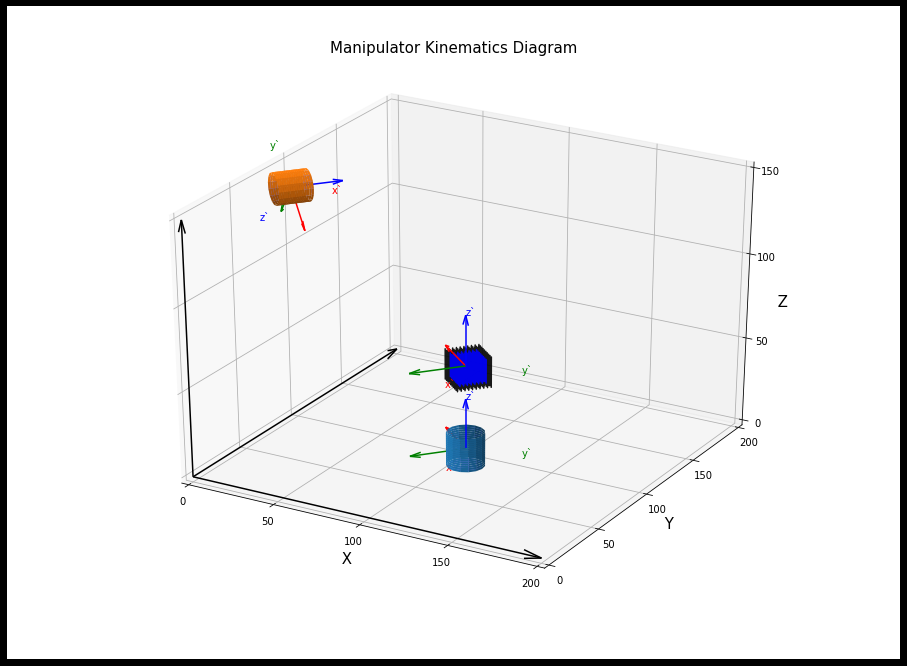

In [47]:
# Graph Properties:
fig = plt.figure(figsize=(16,12), facecolor='k')
ax = fig.add_subplot(111, projection='3d')

for i in range(0, 3600, 5):
    
    start = time.time()
    
    Xmin, Xmax = 0, 200
    Ymin, Ymax = 0, 200
    Zmin, Zmax = 0, 150

    ax.set_xlabel('\n X ', fontsize=15)
    ax.set_ylabel('\n Y ', fontsize=15)
    ax.set_zlabel('\n Z ', fontsize=15)

    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yticks([0, 50, 100, 150, 200])
    ax.set_zticks([0, 50, 100, 150])
    ax.dist = 12

    ax.set_xlim([Xmin, Xmax])
    ax.set_ylim([Ymin, Ymax])
    ax.set_zlim([Zmin, Zmax])

    ax.set_title('Manipulator Kinematics Diagram', fontsize=15)

    ax.quiver(Xmin, 0, 0, Xmax, 0, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, Ymin, 0, 0, Ymax, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, 0, Zmin, 0, 0, Zmax, arrow_length_ratio = 0.05, color='k')

    # Cylinder:
    cX = 100; cY = 100; cZ = 50
    radius = 10
    height = 20
    angle = (0,0,0)
    L = 20

    cX = 100; cY = 100; cZ = 50
    
    Ut3D.drawCylinder(ax, cX, cY, 0, radius, height, (0,0,i))
    Ut3D.drawFrameAxis(ax, cX, cY, 0, 1, (0,0,i))

    Ut3D.drawCube(ax, cX, cY, 50, L, (0,0,i))
    Ut3D.drawFrameAxis(ax, cX, cY, 50, 1, (0,0,i))
    
    RX, RY, RZ = (0,0,i)
    linkLenght = 2*i
    lcX, lcY, lcZ = Ut3D.Rot(RX, RY, RZ).dot(np.array([linkLenght, 0, 0]))
    
    lcX = lcX + cX
    lcY = lcY + cY
    lcZ = lcZ + cZ
    
    Ut3D.drawCylinder(ax, lcX, lcY, lcZ, radius, height, (90,i,i))
    Ut3D.drawFrameAxis(ax, lcX, lcY, lcZ, -1, (0,i,i))
    
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    cv2.imshow("Grid", img)
    
    key = cv2.waitKey(1) or 0xff   
    if key == ord('k'):
        break

    ax.cla()
    
    end = time.time()
    
    # print(start-end)
    
cv2.destroyAllWindows()